### Load s&p500 data

In [179]:
#!pip install pandas pandas-ta numpy matplotlib statsmodels pandas_datareader datetime yfinance scikit-learn PyPortfolioOpt

In [177]:
# from statsmodels.regression.rolling import RollingOLS
# import pandas_datareader.data as web
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# import datetime as dt
# import yfinance as yf
# import pandas_ta
# import warnings
# warnings.filterwarnings('ignore')

# # grab latest sp500 companies
# sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
# result = sp500['Symbol'].str.find('.')
# # print(sp500['Symbol'][result != -1])
# sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
# # print(sp500['Symbol'][result != -1])
# # further improvement here: deal with surviorship bias
# symbols_list = sp500['Symbol'].tolist()

# # end_date = dt.date.today().strftime('%Y-%m-%d')
# end_date = '2025-02-21'
# start_date = pd.to_datetime(end_date)-pd.DateOffset(365*10)

# raw_df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()

In [460]:
daily_df = raw_df.copy(deep=True)
daily_df.index.names = [name.lower() for name in daily_df.index.names]
daily_df.columns = daily_df.columns.str.lower()
daily_df.columns.name = None
daily_df

close        high         low        open       volume
date       ticker                                                             
2015-02-24 A        38.734398   38.780444   38.310767   38.329186    1922100.0
           AAPL     29.517223   29.836584   29.293896   29.689187  276912400.0
           ABBV     40.167542   40.451295   39.936581   40.154343    7900700.0
           ABT      39.234570   39.333750   38.953555   39.069266    4789000.0
           ACGL     18.837299   18.960917   18.815112   18.922880    1518900.0
...                       ...         ...         ...         ...          ...
2025-02-20 XYL     129.729996  130.369995  128.500000  130.369995     830700.0
           YUM     150.250015  150.578450  147.303930  147.303930    2351400.0
           ZBH     103.629997  104.139999  102.790001  103.430000    1374500.0
           ZBRA    320.980011  325.119995  317.589996  324.369995     560600.0
           ZTS     157.419998  158.449997  155.779999  156.639999    4348300.0

[1232090 rows x 5 columns]

In [462]:
monthly_df = (daily_df.groupby([pd.Grouper(level='date', freq='M'), 'ticker'])
              .agg({'close': 'last',
                    'high': 'max',
                    'low': 'min',
                    'open': 'first',
                    'volume': 'sum'})
              .reset_index().set_index(['date', 'ticker']))
monthly_df

close        high         low        open  \
date       ticker                                                   
2015-02-28 A        38.872547   39.130410   38.310767   38.329186   
           AAPL     28.688677   29.836584   28.275513   29.689187   
           ABBV     39.923393   40.451295   39.732024   40.154343   
           ABT      39.151917   39.573440   38.928773   39.069266   
           ACGL     18.751719   18.960917   18.517164   18.922880   
...                       ...         ...         ...         ...   
2025-02-28 XYL     129.729996  132.489101  120.157355  121.931851   
           YUM     150.250015  150.578450  128.124554  128.831222   
           ZBH     103.629997  108.889999   97.690002  108.000000   
           ZBRA    320.980011  390.880005  312.369995  384.100006   
           ZTS     157.419998  177.399994  154.320007  169.059998   

                         volume  
date       ticker                
2015-02-28 A       7.447300e+06  
           AAPL    1.188968e+09  
           ABBV    3.386190e+07  
           ABT     2.048450e+07  
           ACGL    7.166700e+06  
...                         ...  
2025-02-28 XYL     1.948160e+07  
           YUM     3.330450e+07  
           ZBH     2.786640e+07  
           ZBRA    1.141370e+07  
           ZTS     5.509020e+07  

[59304 rows x 5 columns]

### Features extraction

In [464]:
# Garman Klass Volatility (captures intraday high low vol)
def compute_gk(df):
    return 0.5*(np.log(df['high']/df['low']))**2-(2*np.log(2)-1)*(np.log(df['close']/df['open']))**2

daily_df['garman_klass_vol'] = compute_gk(daily_df)
monthly_df['garman_klass_vol'] = compute_gk(monthly_df)

In [465]:
# RSI (magnitude of recent gains to recent losses): 100 - 100/(1+RS)
# - RS = avg gain/avg loss
def compute_rsi(close, length, window, min_periods):
    rsi = pandas_ta.rsi(close=close, length=length)
    
    rolling_mean = rsi.rolling(window=window, min_periods=min_periods).mean()
    rolling_std = rsi.rolling(window=window, min_periods=min_periods).std()
    # Normalized for cross securities comparison
    return rsi.sub(rolling_mean).div(rolling_std + 1e-10) # safeguard div by zero

daily_df['rsi'] = daily_df.groupby(level='ticker', group_keys=False)['close'].apply(compute_rsi, 14, 50, 14)
monthly_df['rsi'] = monthly_df.groupby(level='ticker', group_keys=False)['close'].apply(compute_rsi, 6, 12, 6)

In [466]:
# Bollinger Bands
# - mid = simple moving avg (SMA)
# - low = SMA - 2 x SD
# - high = SMA + 2 x SD
def compute_bbs(close, length, window, min_periods):
    bbs = pandas_ta.bbands(np.log1p(close), length=length).iloc[:,0:3]

    rolling_mean = bbs.rolling(window=window, min_periods=min_periods).mean()
    rolling_std = bbs.rolling(window=window, min_periods=min_periods).std()
    
    return bbs.sub(rolling_mean).div(rolling_std + 1e-10)

daily_df[['bb_low', 'bb_mid', 'bb_high']] = daily_df.groupby(level='ticker', group_keys=False)['close'].apply(compute_bbs, 20, 50, 20)
monthly_df[['bb_low', 'bb_mid', 'bb_high']] = monthly_df.groupby(level='ticker', group_keys=False)['close'].apply(compute_bbs, 6, 12, 6)

In [467]:
# ATR (Moving average of True Range (TR))
# TR = Max[(High - Low), |High - Prev Close|, |Low - Prev Close|]
def compute_atr(stock_data, length, window, min_periods):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=length)
    
    rolling_mean = atr.rolling(window=window, min_periods=min_periods).mean()
    rolling_std = atr.rolling(window=window, min_periods=min_periods).std()
    
    return atr.sub(rolling_mean).div(rolling_std + 1e-10)

daily_df['atr'] = daily_df.groupby(level='ticker', group_keys=False).apply(compute_atr, 14, 50, 14)
monthly_df['atr'] = monthly_df.groupby(level='ticker', group_keys=False).apply(compute_atr, 6, 12, 6)

In [470]:
# MACD (includes MACD Line, Signal Line, and Histogram)
# - MACD Line = fast exp moving avg (EMA) - slow EMA
# - Signal Line = x days EMA of MACD Line
# - Histogram = MACD Line - Signal Line
def compute_macd(close, fast, slow, signal, window, min_periods):
    macd = pandas_ta.macd(close=close, fast=fast, slow=slow, signal=signal).iloc[:,0] # just MACD line

    rolling_mean = macd.rolling(window=window, min_periods=min_periods).mean()
    rolling_std = macd.rolling(window=window, min_periods=min_periods).std()
    
    return macd.sub(rolling_mean).div(rolling_std + 1e-10)

daily_df['macd'] = daily_df.groupby(level='ticker', group_keys=False)['close'].apply(compute_macd, 12, 26, 9, 50, 12)
monthly_df['macd'] = monthly_df.groupby(level='ticker', group_keys=False)['close'].apply(compute_macd, 3, 6, 2, 12, 2)

In [471]:
# Dollar Volume (price x volume) in million
daily_df['dollar_volume'] = (daily_df['close'] * daily_df['volume']) / 1e6
monthly_df['dollar_volume'] = daily_df.groupby([pd.Grouper(level='date', freq='M'), 'ticker'])['dollar_volume'].sum()

In [472]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1232090 entries, (Timestamp('2015-02-24 00:00:00'), 'A') to (Timestamp('2025-02-20 00:00:00'), 'ZTS')
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   close             1232090 non-null  float64
 1   high              1232090 non-null  float64
 2   low               1232090 non-null  float64
 3   open              1232090 non-null  float64
 4   volume            1232090 non-null  float64
 5   garman_klass_vol  1232090 non-null  float64
 6   rsi               1218508 non-null  float64
 7   bb_low            1212976 non-null  float64
 8   bb_mid            1212976 non-null  float64
 9   bb_high           1212976 non-null  float64
 10  atr               1218509 non-null  float64
 11  macd              1213982 non-null  float64
 12  dollar_volume     1232090 non-null  float64
dtypes: float64(13)
memory usage: 127.0+ MB


In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1232090 entries, (Timestamp('2015-02-24 00:00:00'), 'A') to (Timestamp('2025-02-20 00:00:00'), 'ZTS')
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   close             1232090 non-null  float64
 1   high              1232090 non-null  float64
 2   low               1232090 non-null  float64
 3   open              1232090 non-null  float64
 4   volume            1232090 non-null  float64
 5   garman_klass_vol  1232090 non-null  float64
 6   rsi               1218508 non-null  float64
 7   bb_low            1212976 non-null  float64
 8   bb_mid            1212976 non-null  float64
 9   bb_high           1212976 non-null  float64
 10  atr               1218509 non-null  float64
 11  macd              1213982 non-null  float64
 12  dollar_volume     1232090 non-null  float64
dtypes: float64(13)
memory usage: 127.0+ MB


In [474]:
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 59304 entries, (Timestamp('2015-02-28 00:00:00'), 'A') to (Timestamp('2025-02-28 00:00:00'), 'ZTS')
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   close             59304 non-null  float64
 1   high              59304 non-null  float64
 2   low               59304 non-null  float64
 3   open              59304 non-null  float64
 4   volume            59304 non-null  float64
 5   garman_klass_vol  59304 non-null  float64
 6   rsi               53774 non-null  float64
 7   bb_low            54276 non-null  float64
 8   bb_mid            54276 non-null  float64
 9   bb_high           54276 non-null  float64
 10  atr               53774 non-null  float64
 11  macd              56286 non-null  float64
 12  dollar_volume     59304 non-null  float64
dtypes: float64(13)
memory usage: 6.1+ MB


In [564]:
# 5-year rolling avg of dollar volume and filter top 150

# rolling window 60 months, min periods 12 months
def filter_data(data):
    data['dollar_volume'] = (data['dollar_volume'].unstack('ticker').rolling(window=5*12, min_periods=12).mean().stack())
    data['dollar_vol_rank'] = data.groupby(level='date')['dollar_volume'].rank(ascending=False)
    return data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

# method 1: convert daily data to month-end frequency
# monthly mean for dollar volume
tmp_1 = daily_df.unstack()['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

# last day data of each month for close, gk vol, rsi, bb, atr, macd
tmp_2 = daily_df.unstack()[['close', 'garman_klass_vol', 'rsi', 'bb_mid', 'bb_low', 'bb_high', 'atr', 'macd']].resample('M').last().stack('ticker')
data_month_end = pd.concat([tmp_1, tmp_2], axis=1).dropna()

# method 2: calculate monthly prices and indicators from start
data_month = monthly_df.copy(deep=True)
data_month = data_month.loc[:, data_month_end.columns].dropna()

data_month_end = filter_data(data_month_end)
data_month = filter_data(data_month)
print(data_month_end.shape)
print(data_month.shape)

(16092, 8)
(14751, 8)


### Calculate monthly returns

In [566]:
def calculate_returns(df):
    cutoff = 0.005 # assume outliers
    lags = [1,2,3,6,9,12] # months
    for lag in lags:
        df[f'return_{lag}m'] = (df['close'].pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(cutoff), upper=x.quantile(1-cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df

data_month_end = data_month_end.groupby(level='ticker', group_keys=False).apply(calculate_returns).dropna()
data_month = data_month.groupby(level='ticker', group_keys=False).apply(calculate_returns).dropna()
print(data_month_end.shape)
print(data_month.shape)

(13767, 14)
(12487, 14)


In [567]:
data_month_end.xs('AAPL', level='ticker')['2024':'2024-05'].iloc[:,-6:]

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
date,,,,,,
2024-01-31,-0.042227,-0.014717,0.026377,-0.010055,0.009741,0.021125
2024-02-29,-0.018543,-0.030457,-0.015994,-0.005989,0.002614,0.017588
2024-03-31,-0.051286,-0.035054,-0.037451,0.000695,-0.013168,0.003711
2024-04-30,-0.006706,-0.029252,-0.025696,0.000002,-0.015296,0.000763
2024-05-31,0.130222,0.059548,0.021235,0.002447,0.003004,0.007237


In [568]:
data_month.xs('AAPL', level='ticker')['2024':'2024-05'].iloc[:,-6:]

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
date,,,,,,
2024-01-31,-0.042227,-0.014717,0.026377,-0.010055,0.009741,0.021125
2024-02-29,-0.018543,-0.030457,-0.015994,-0.005989,0.002614,0.017588
2024-03-31,-0.051286,-0.035054,-0.037451,0.000695,-0.013168,0.003711
2024-04-30,-0.006706,-0.029252,-0.025696,0.000002,-0.015296,0.000763
2024-05-31,0.130222,0.059548,0.021235,0.002447,0.003004,0.007237


## Fama-French Factors and Rolling Factor Betas

In [570]:
# Fama-French factors explain returns through systematic risks (market, size, value, profitability, investment)
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'

f_data_me = factor_data.join(data_month_end['return_1m']).sort_index()
f_data_m = factor_data.join(data_month['return_1m']).sort_index()

# filter out stocks with not enough data, i.e. with less than 12 months data
# note that we had filtered top 150 stock in terms of dollar volume (5-year rolling avg)
def filter_factor_data(factor_data):
    observations = factor_data.groupby(level='ticker').size()
    valid_stocks = observations[observations>=12]
    return factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
    
f_data_me = filter_factor_data(f_data_me)
f_data_m = filter_factor_data(f_data_m)

In [572]:
# Rolling Factor Betas
import statsmodels as sm

def rolling_factor_betas(factor_data):
    return (factor_data.groupby(level='ticker', group_keys=False)
            .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                         exog=sm.tools.add_constant(x.drop(['return_1m'], axis=1)),
                                         window=min(24, x.shape[0]),
                                         min_nobs=len(x.columns)+1)
            .fit()
            .params
            .drop('const', axis=1)))

betas_me = rolling_factor_betas(f_data_me)
betas_m = rolling_factor_betas(f_data_m)
print(betas_me.shape)
print(betas_m.shape)

(13448, 5)
(12143, 5)


### shift betas one month forward since we are using month end return

In [574]:
beta_cols = ['Mkt-RF','SMB','HML','RMW','CMA']

def join_betas(data, betas, beta_cols):
    data = data.join(betas)
    # Shift only betas columns within each ticker
    return data.groupby('ticker')[beta_cols].shift(1)

data_month_end[beta_cols] = join_betas(data_month_end, betas_me, beta_cols)
data_month[beta_cols] = join_betas(data_month, betas_m, beta_cols)
print(data_month_end.shape)
print(data_month.shape)

(13767, 19)
(12487, 19)


In [575]:
# handle NaN values

def handle_nan(data, beta_cols):
    # remove "buffer" data
    data = data[data.index.get_level_values('date') >= pd.Timestamp('2019-03')]
    # fill NaN with mean
    data.loc[:,beta_cols] = data.groupby('ticker', group_keys=False)[beta_cols].apply(lambda x: x.fillna(x.mean()))
    # drop remaining NaN ticker
    nan_rows = data[beta_cols].isna().any(axis=1)
    nan_tickers = data.loc[nan_rows].index.get_level_values('ticker').unique()
    data = data.drop('close', axis=1).dropna()
    return data

data_month_end = handle_nan(data_month_end, beta_cols)
data_month = handle_nan(data_month, beta_cols)
print(data_month_end.shape)
print(data_month.shape)

(10264, 18)
(10298, 18)


In [576]:
data_month_end.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10264 entries, (Timestamp('2019-03-31 00:00:00'), 'AAPL') to (Timestamp('2025-02-28 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10264 non-null  float64
 1   rsi               10264 non-null  float64
 2   bb_mid            10264 non-null  float64
 3   bb_low            10264 non-null  float64
 4   bb_high           10264 non-null  float64
 5   atr               10264 non-null  float64
 6   macd              10264 non-null  float64
 7   return_1m         10264 non-null  float64
 8   return_2m         10264 non-null  float64
 9   return_3m         10264 non-null  float64
 10  return_6m         10264 non-null  float64
 11  return_9m         10264 non-null  float64
 12  return_12m        10264 non-null  float64
 13  Mkt-RF            10264 non-null  float64
 14  SMB               10264 non-null  float64
 15  HML       

In [577]:
data_month.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10298 entries, (Timestamp('2019-03-31 00:00:00'), 'AAPL') to (Timestamp('2025-02-28 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10298 non-null  float64
 1   rsi               10298 non-null  float64
 2   bb_mid            10298 non-null  float64
 3   bb_low            10298 non-null  float64
 4   bb_high           10298 non-null  float64
 5   atr               10298 non-null  float64
 6   macd              10298 non-null  float64
 7   return_1m         10298 non-null  float64
 8   return_2m         10298 non-null  float64
 9   return_3m         10298 non-null  float64
 10  return_6m         10298 non-null  float64
 11  return_9m         10298 non-null  float64
 12  return_12m        10298 non-null  float64
 13  Mkt-RF            10298 non-null  float64
 14  SMB               10298 non-null  float64
 15  HML       

### ML Model

In [944]:
X_me = data_month_end.copy(deep=True)
X_m = data_month.copy(deep=True)

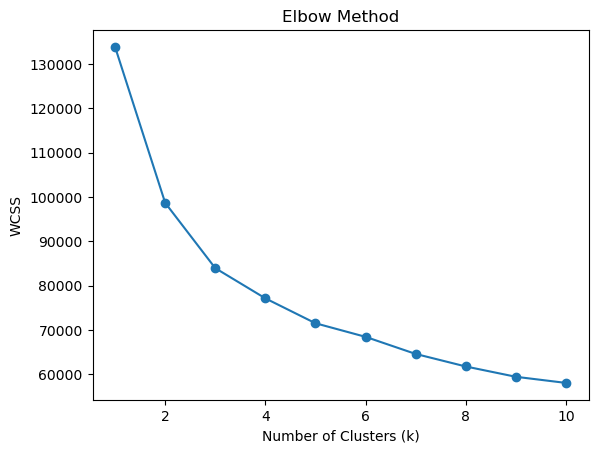

In [950]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

features_cols = [
    'garman_klass_vol', 'rsi', 'bb_mid', 'bb_low', 'bb_high', 'atr', 'macd',
    'return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m', 'return_12m',
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'
]

# choose k based on elbow point

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_m)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [952]:
# cluster data into 4 clusters
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                             random_state=0,
                             init='random').fit(df).labels_
    return df

clustered_X_m = X_m.dropna().groupby('date',group_keys=False).apply(get_clusters)

Explained variance ratio (3D): [0.34897454 0.19329161 0.12499134]
Total variance explained: 66.73%


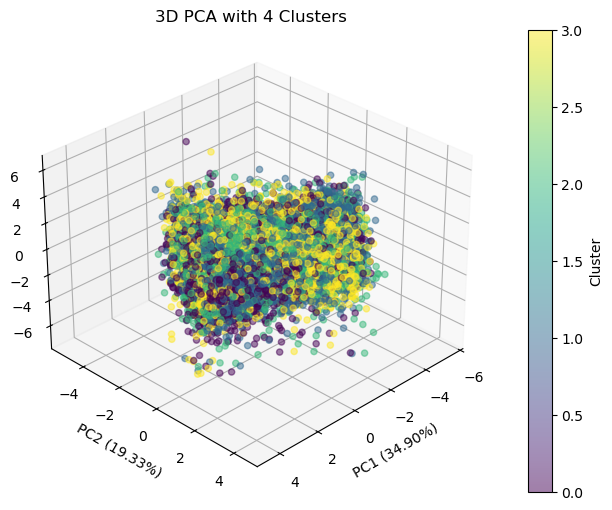

Cluster Summary for k=4:
         garman_klass_vol     rsi  bb_mid  bb_low  bb_high     atr    macd  \
cluster                                                                      
0                  0.0100  0.0963  0.7495  0.6126   0.6941  0.3184  0.1696   
1                  0.0104  0.0333  0.2895  0.2635   0.2584  0.0589  0.1009   
2                  0.0118  0.0209  0.4911  0.4533   0.4375  0.1793  0.0814   
3                  0.0098  0.0573  0.4623  0.3687   0.4708  0.2668  0.1226   

         return_1m  return_2m  return_3m  return_6m  return_9m  return_12m  \
cluster                                                                      
0           0.0149     0.0143     0.0136     0.0145     0.0147      0.0141   
1           0.0157     0.0086     0.0095     0.0059     0.0050      0.0050   
2           0.0102     0.0125     0.0116     0.0106     0.0100      0.0099   
3           0.0162     0.0123     0.0105     0.0100     0.0092      0.0090   

         Mkt-RF     SMB     HML     R

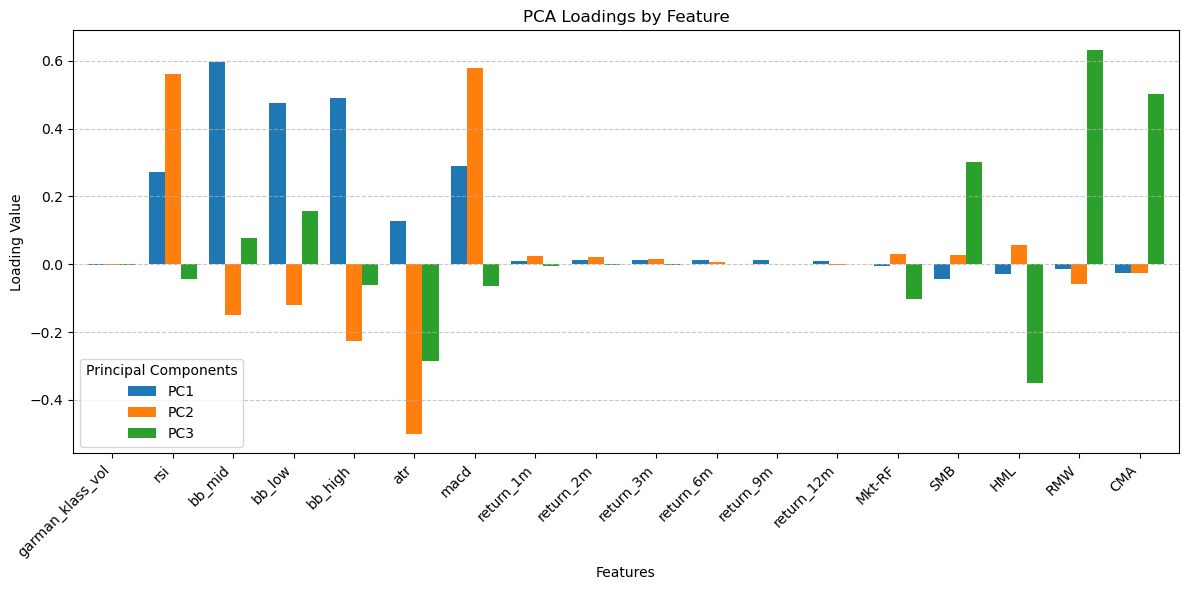

In [961]:
# Visualize data
from sklearn.decomposition import PCA

pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(clustered_X_m[features_cols])
print(f"Explained variance ratio (3D): {pca_3d.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca_3d.explained_variance_ratio_)*100:.2f}%")

# 3D plot
plot_data = pd.DataFrame(pca_result_3d, index=clustered_data.index, columns=['pca1', 'pca2', 'pca3'])
plot_data['cluster'] = clustered_X_m['cluster']

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(plot_data['pca1'], plot_data['pca2'], plot_data['pca3'], 
                     c=plot_data['cluster'], cmap='viridis', alpha=0.5)
ax.set_title('3D PCA with 4 Clusters')
ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.2f}%)')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.2f}%)')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.2f}%)')
plt.colorbar(scatter, label='Cluster')
ax.view_init(30, 45)
plt.show()

# Cluster Summary
cluster_summary = clustered_X_m.groupby('cluster')[features_cols].mean().round(4)
print("Cluster Summary for k=4:")
print(cluster_summary)

# Loadings SUmmary
loadings = pd.DataFrame(pca_3d.components_.T, index=features_cols, columns=['PC1', 'PC2', 'PC3'])
print("PCA Loadings:")
print(loadings.round(4))

# Bar Plot
loadings.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('PCA Loadings by Feature')
plt.xlabel('Features')
plt.ylabel('Loading Value')
plt.legend(title='Principal Components')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Select stocks based on clustering results

In [969]:
# Analysis base on cluster summary and loading results:

# Goal: maximizing returns while managing risk

# 1. Growth (High Returns):
#     Cluster 3: 
#         - Highest return_1m (0.0162)
#         - low garman_klass_vol (0.0098)
#     -> decent momentum, best short-term growth
    
#     Cluster 0: 
#         - Consistent returns (e.g., return_12m: 0.0141)
#     -> strong momentum — best long-term growth
    
# 2. Stability:
#     Cluster 1: 
#         - Lowest atr (0.0589)
#         - solid return_1m (0.0157)
#     -> stable short-term performer
    
# 3. Momentum:
#     Cluster 0: 
#         - Highest rsi (0.0963), macd (0.1696), bb_mid (0.7495)
#     -> strongest trend.

# Avoid:
#     Cluster 2: Lowest returns, highest volatility —> least attractive

# Top choices:
#     Cluster 0 (Momentum/Value): 
#         - High PC1 (trend/momentum), consistent returns, value tilt (HML)
#         - Best for long-term growth with momentum
#     Cluster 3 (Short-term/Profitability): 
#         - High PC3 (profitability/small-cap), top return_1m (0.0162)
#         - Best for short-term gains with stability

#### if we choose cluster 3

In [1215]:
best_cluster = 3
data_filterd = clustered_X_m[clustered_X_m['cluster'] == best_cluster].copy(deep=True)
data_filterd = data_filterd.reset_index(level='ticker')
# invest last month stock selection in next month
data_filterd.index = data_filterd.index+pd.DateOffset(1)
data_filterd = data_filterd.reset_index().set_index(['date', 'ticker'])
# create the stock pick list
dates = data_filterd.index.get_level_values('date').unique().tolist()
stock_picks = {}
for d in dates:
    stock_picks[d.strftime('%Y-%m-%d')] = data_filterd.xs(d, level='date').index.to_list()

stock_picks

{'2019-04-01': ['AAPL',
  'ACN',
  'CL',
  'CVX',
  'DLTR',
  'EBAY',
  'GM',
  'HON',
  'IBM',
  'INTC',
  'MMM',
  'MO',
  'NXPI',
  'PM',
  'T',
  'TGT',
  'XOM'],
 '2019-05-01': ['ABT',
  'ACN',
  'ADBE',
  'ADP',
  'ADSK',
  'AMD',
  'AMT',
  'AVGO',
  'AXP',
  'AZO',
  'BRK-B',
  'CHTR',
  'CMCSA',
  'CMG',
  'COST',
  'CRM',
  'CSCO',
  'CSX',
  'DE',
  'DG',
  'DHR',
  'DIS',
  'DLTR',
  'GM',
  'HON',
  'INTC',
  'JNJ',
  'KO',
  'LOW',
  'MA',
  'MCD',
  'MDLZ',
  'MSFT',
  'NEE',
  'NKE',
  'ORCL',
  'PANW',
  'PEP',
  'PG',
  'PYPL',
  'SBUX',
  'SHW',
  'TMO',
  'TMUS',
  'ULTA',
  'UNP',
  'V',
  'VZ',
  'WMT'],
 '2019-06-01': ['ABT',
  'AMGN',
  'AMZN',
  'BA',
  'BDX',
  'BRK-B',
  'BSX',
  'CRM',
  'CVX',
  'DE',
  'ELV',
  'GM',
  'GOOG',
  'GOOGL',
  'HD',
  'INTC',
  'ISRG',
  'JNJ',
  'LLY',
  'LOW',
  'MDT',
  'MRK',
  'NFLX',
  'NKE',
  'ORLY',
  'PANW',
  'PFE',
  'REGN',
  'SHW',
  'TJX',
  'UAL',
  'UNH',
  'VRTX',
  'VZ'],
 '2019-07-01': ['ABT',
  'ACN',
  'A

### Portfolio optimization function

In [1200]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0, upper_bound=1, risk_free_rate=0.0):
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    print(f"Expected Returns:\n{returns}")
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    ef = EfficientFrontier(expected_returns=returns, 
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, upper_bound), # ensure portfolio is diversified enough
                           solver='SCS')

    # Check if any return exceeds risk-free rate
    if max(returns) > risk_free_rate:
        weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
        print(f"Optimized for max Sharpe with risk-free rate {risk_free_rate}")
    else:
        weights = ef.min_volatility()
        print("All returns below risk-free rate; optimized for min volatility")
    
    return ef.clean_weights()

In [1213]:
# stocks = data_month.index.get_level_values('ticker').unique().to_list()
# new_df = yf.download(tickers=stocks,
#                      start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
#                      end=data.index.get_level_values('date').unique()[-1])
# new_df

In [1203]:
returns_df = np.log(new_df['Close']).diff()
portfolio_df = pd.DataFrame()

for st_date in stock_picks.keys():
    ed_date = (pd.to_datetime(st_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    # required one year prior return for optimization
    # !! historical data might not do a good job on return estimation !!
    opt_st_date = (pd.to_datetime(st_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    opt_ed_date = (pd.to_datetime(st_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    
    cols = stock_picks[st_date]
    opt_df = new_df.loc[opt_st_date:opt_ed_date]['Close'][cols]

    success = False
    try:
        #lower bound = half of equal weight (changable)
        lower_bound = round((1/len(opt_df.columns))*0.5,4)
        upper_bound = 0.1
        weights = optimize_weights(prices=opt_df, lower_bound=lower_bound, upper_bound=upper_bound)
        weights = pd.DataFrame(weights, index=pd.Series(0))
        success = True
    except:
        print(f'Max Sharpe Opt failed for {st_date}, continuing with Equal Weight')
    if not success:
        weights = pd.DataFrame([1/len(opt_df.columns) for i in range(len(opt_df.columns))],
                               index=opt_df.columns.to_list(),
                               columns=pd.Series(0)).T
        
    weights = weights.stack().to_frame('weight').reset_index(level=0, drop=True)
    tmp_df = returns_df[st_date:ed_date]
    tmp_df = tmp_df.stack().to_frame('return').reset_index(level='Date')
    tmp_df = tmp_df.merge(weights, left_index=True, right_index=True).reset_index().set_index(['Date', 'Ticker'])
    
    tmp_df['weighted_return'] = tmp_df['return']*tmp_df['weight']
    tmp_df = tmp_df.groupby(level='Date')['weighted_return'].sum().to_frame('first strat return')
    portfolio_df = pd.concat([portfolio_df, tmp_df], axis=0)

Expected Returns:
Ticker
AAPL    0.158312
ACN     0.212804
CL      0.002429
CVX     0.141116
DLTR    0.113663
EBAY   -0.053286
GM      0.080311
HON     0.190295
IBM    -0.015610
INTC    0.125895
MMM     0.004208
MO      0.003329
NXPI   -0.227891
PM     -0.041963
T      -0.031767
TGT     0.204894
XOM     0.151542
dtype: float64
Optimized for max Sharpe with risk-free rate 0.0
Expected Returns:
Ticker
ABT      0.379723
ACN      0.225425
ADBE     0.293473
ADP      0.416539
ADSK     0.406367
AMD      1.500603
AMT      0.481099
AVGO     0.442915
AXP      0.208740
AZO      0.633005
BRK-B    0.111640
CHTR     0.331548
CMCSA    0.391531
CMG      0.621285
COST     0.264692
CRM      0.346281
CSCO     0.286735
CSX      0.350729
DE       0.249851
DG       0.323488
DHR      0.323578
DIS      0.394258
DLTR     0.161391
GM       0.113898
HON      0.282513
INTC    -0.019444
JNJ      0.152499
KO       0.193312
LOW      0.393551
MA       0.422289
MCD      0.241617
MDLZ     0.337810
MSFT     0.401693
NEE

### Visualize portfolio returns and benchmark

In [1205]:
# spy = yf.download(tickers='SPY', start=start_date, end=end_date)

In [1206]:
spy_ret = np.log(spy['Close']).diff().dropna()
compare_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

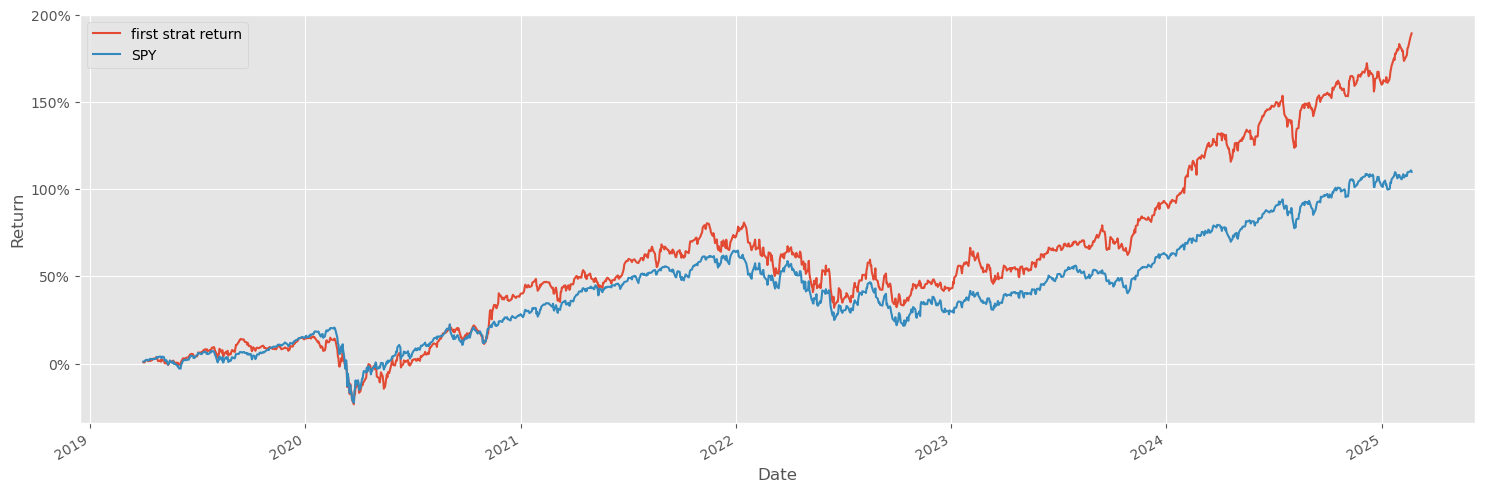

In [1207]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

compare_cum_ret = np.expm1(np.log1p(compare_df).cumsum())

compare_cum_ret.plot(figsize=(18,6))

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()